In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import time
import psutil

# Function to calculate memory usage
def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Memory in MB


In [3]:
data_dir = '/content/drive/MyDrive/data'
train_dir = os.path.join(data_dir)


In [4]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Prepare train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='binary',  # Assuming binary classification (galaxy, star)
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 3198 images belonging to 2 classes.
Found 798 images belonging to 2 classes.


#CNN MODEL

In [5]:
from tensorflow.keras.layers import Input

# Define input layer using Input() instead of passing input_shape in the first Conv2D layer
model = tf.keras.models.Sequential([
    Input(shape=(64, 64, 3)),  # Specify input shape here
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Record start time and memory usage
start_time = time.time()
start_memory = memory_usage()

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator
)

# Record end time and memory usage
end_time = time.time()
end_memory = memory_usage()

execution_time = end_time - start_time
memory_used = end_memory - start_memory


Epoch 1/2
100/100 [==============================] - 40s 386ms/step - loss: 0.5213 - accuracy: 0.7639 - val_loss: 0.4156 - val_accuracy: 0.7807
Epoch 2/2
100/100 [==============================] - 42s 421ms/step - loss: 0.3668 - accuracy: 0.8296 - val_loss: 0.3102 - val_accuracy: 0.8722


In [7]:
# Predict on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.round(Y_pred).astype(int)

# Print classification report
print("Classification Report:\n", classification_report(validation_generator.classes, y_pred, target_names=['Galaxy', 'Star']))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(validation_generator.classes, y_pred))


25/25 [==============================] - 5s 177ms/step
Classification Report:
               precision    recall  f1-score   support

      Galaxy       0.18      0.14      0.15       188
        Star       0.75      0.80      0.77       610

    accuracy                           0.64       798
   macro avg       0.46      0.47      0.46       798
weighted avg       0.62      0.64      0.63       798

Confusion Matrix:
 [[ 26 162]
 [122 488]]


In [8]:
from tabulate import tabulate

# Tabulate metrics
metrics = [
    ['Execution Time (s)', execution_time],
    ['Memory Used (MB)', memory_used],
    ['Accuracy', history.history['accuracy'][-1]],
    ['Validation Accuracy', history.history['val_accuracy'][-1]],
    ['Loss', history.history['loss'][-1]],
    ['Validation Loss', history.history['val_loss'][-1]]
]

print(tabulate(metrics, headers=['Metric', 'Value']))


Metric                    Value
-------------------  ----------
Execution Time (s)    82.2918
Memory Used (MB)     125.117
Accuracy               0.829581
Validation Accuracy    0.87218
Loss                   0.366795
Validation Loss        0.310243


#HYBRID QCNN MODEL

In [13]:
!pip install pennylane tensorflow matplotlib scikit-learn psutil tabulate


In [10]:
import os
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import pennylane as qml
import tensorflow as tf

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Function to calculate memory usage
def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Memory in MB

# Data directory
data_dir = '/content/drive/MyDrive/data'

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Prepare train and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Quantum device setup (4 qubits, and a default simulator)
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Quantum layer using PennyLane's KerasLayer
weight_shapes = {"weights": (3, n_qubits)}
qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

# Define a hybrid classical-quantum CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),  # Changed from 16 to 4
    qlayer,  # Add quantum layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])



# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Record start time and memory usage
start_time = time.time()
start_memory = memory_usage()

# Train the model
history = model.fit(
    train_generator,
    epochs=1,  # Can increase the number of epochs for better training
    validation_data=validation_generator
)

# Record end time and memory usage
end_time = time.time()
end_memory = memory_usage()

execution_time = end_time - start_time
memory_used = end_memory - start_memory



# Predict on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.round(Y_pred).astype(int)

# Print classification report
print("Classification Report:\n", classification_report(validation_generator.classes, y_pred, target_names=['Galaxy', 'Star']))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(validation_generator.classes, y_pred))

# Tabulate metrics
metrics = [
    ['Execution Time (s)', execution_time],
    ['Memory Used (MB)', memory_used],
    ['Accuracy', history.history['accuracy'][-1]],
    ['Validation Accuracy', history.history['val_accuracy'][-1]],
    ['Loss', history.history['loss'][-1]],
    ['Validation Loss', history.history['val_loss'][-1]]
]

print(tabulate(metrics, headers=['Metric', 'Value']))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3198 images belonging to 2 classes.
Found 798 images belonging to 2 classes.
25/25 [==============================] - 6s 231ms/step
Classification Report:
               precision    recall  f1-score   support

      Galaxy       0.00      0.00      0.00       188
        Star       0.76      1.00      0.87       610

    accuracy                           0.76       798
   macro avg       0.38      0.50      0.43       798
weighted avg       0.58      0.76      0.66       798

Confusion Matrix:
 [[  0 188]
 [  0 610]]
Metric                    Value
-------------------  ----------
Execution Time (s)    53.4667
Memory Used (MB)     103.844
Accuracy               0.764228
Validation Accuracy    0.764411
Loss                   0.598027
Validation Loss        0.571929


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#COMPARISON CNN VS HYBRID QCNN

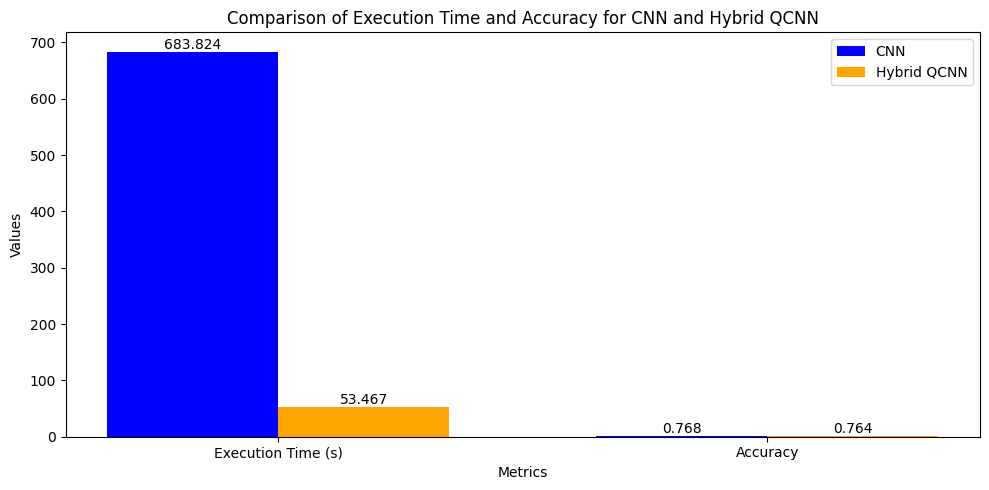

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics data
metrics = ['Execution Time (s)', 'Accuracy']
cnn_values = [683.824, 0.768025]
qcnn_values = [53.4667, 0.764228]

# Create bar width
bar_width = 0.35
index = np.arange(len(metrics))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Bars for CNN
bars1 = ax.bar(index, cnn_values, bar_width, label='CNN', color='blue')

# Bars for Hybrid QCNN
bars2 = ax.bar(index + bar_width, qcnn_values, bar_width, label='Hybrid QCNN', color='orange')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Execution Time and Accuracy for CNN and Hybrid QCNN')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Adding value labels on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()
